# モジュールのインポート

In [1]:
import re
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import openpyxl
from openpyxl.drawing.line import LineProperties
from openpyxl.chart.shapes import GraphicalProperties
from openpyxl.chart.text import RichText
from openpyxl.drawing.text import Paragraph, ParagraphProperties, CharacterProperties, Font

# 必要情報を入力

In [4]:
# 各フォルダの読み込み
# folder_list = glob.glob(r'C:\Users\west7\OneDrive\デスクトップ\raman処理用\data\*')
# folder_list = glob.glob(r'C:\Users\r-swx\OneDrive\デスクトップ\raman_data\data\*')
folder_list = glob.glob(r'.\input\spectra_data\*')

# データの区切りを指定（タブ：'\t', コンマ：',', セミコロン：';'）
sep = '[,;\t]'

# excelファイルの保存先のパス
# excel_path = r'C:\Users\west7\OneDrive\デスクトップ\raman処理用\\'
# excel_path = r'C:\Users\r-swx\OneDrive\デスクトップ\raman_data\\'
output_path = r'.\output\\'

# データの読み込み

In [5]:
file_dic = {}
for n, folder in enumerate(folder_list):
    file_dic[f'data_{n+1}'] = glob.glob(folder + '\*')

df_list = []

for folder in file_dic:
    # フォルダ内にファイルがある場合
    if len(file_dic[folder]) > 0:
        # 各種データ保存用のディクショナリを作成
        data_dic = {}

        # テクストファイルの読み込み
        for file in file_dic[folder]:
            # ファイル名の切り取り
            file_name = re.split('[\\\\.]', file)[5]

            # 一時保存用リストの作成
            temp_list = []

            # スペクトルデータの読み込み
            with open(file, encoding='utf-8') as f:
                for row in f:
                    row = row.strip()
                    temp_list.append(re.split(sep, row))
            temp_list = temp_list[32:1069]

            # ディクショナリへデータの格納
            data_dic[file_name] = temp_list

        # 空のデータフレームを作成
        df = pd.DataFrame()

        # フォルダ内データをデータフレームに追加
        for key in data_dic:
            intensity_list = []
            wave_list = []

            for n in range(len(data_dic[key])):
                intensity_list.append(data_dic[key][n][3])

            for n in range(len(data_dic[key])):
                wave_list.append(data_dic[key][n][0])

            df['Raman Shift'] = wave_list
            df[key] = intensity_list

        df = df.astype(float)
        df = df.sort_values(by=['Raman Shift'], ascending=True).reset_index(drop=True)

        df_list.append(df)

    else:
        break

# グラフの可視化

In [22]:
# X軸の最大・最小の設定
XLIM_MIN = 200
XLIM_MAX = 1700
# Y軸の最大・最小の設定
YLIM_MIN = -1000
YLIM_MAX = 20000
# 軸ラベルの設定
XLABEL = 'Raman Shift [cm^-1]'
YLABEL = 'Intensity [a.u.]'
# グラフサイズ
GRAPH_SIZE = (8, 6)
# フォントサイズ
FONTS_SIZE = 14

In [23]:
def show_raman_spectra(spectra_df_list):
    """
    ラマンスペクトルを表示する関数
    :param spectra_df_list: 各スペクトルデータフレームのリスト
    """
    for df in spectra_df_list:
        yaxis_list = [y for y in df.columns if not 'Raman Shift' in y]
        plt.figure(figsize=(25, 4))
        for i in range(5):
            plt.subplot(1, 5, i+1)
            plt.plot(df['Raman Shift'] , df[yaxis_list[i*10]])
            plt.title(yaxis_list[i*10])
            plt.xlim(XLIM_MIN, XLIM_MAX)
            plt.ylim(YLIM_MIN, YLIM_MAX)

        # plt.xlabel(XLABEL)
        # plt.ylabel(YLABEL)
        # plt.xticks(fontsize=FONTS_SIZE)
        # plt.yticks(fontsize=FONTS_SIZE)
        plt.tight_layout()
        plt.show()

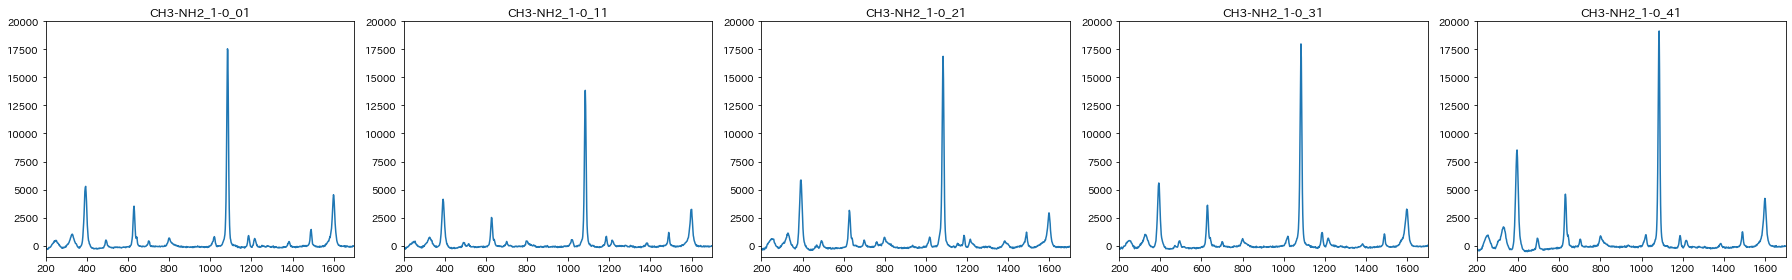

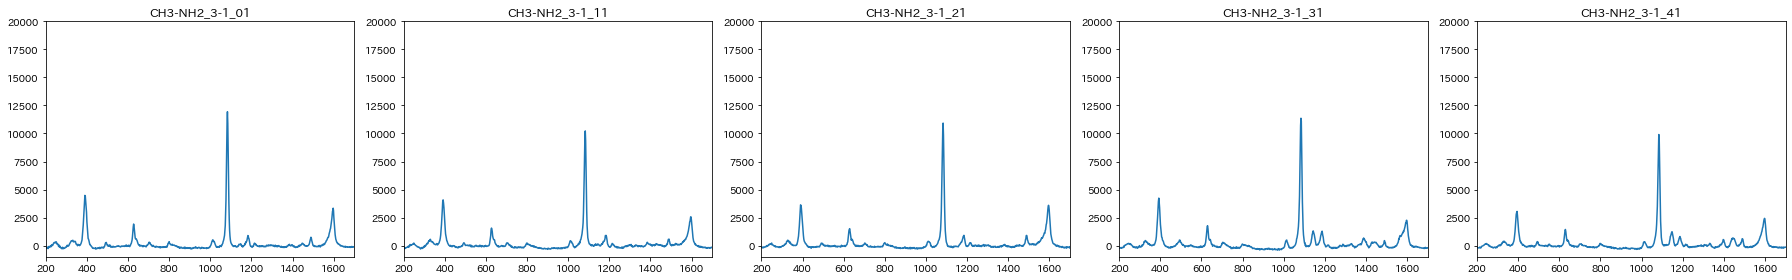

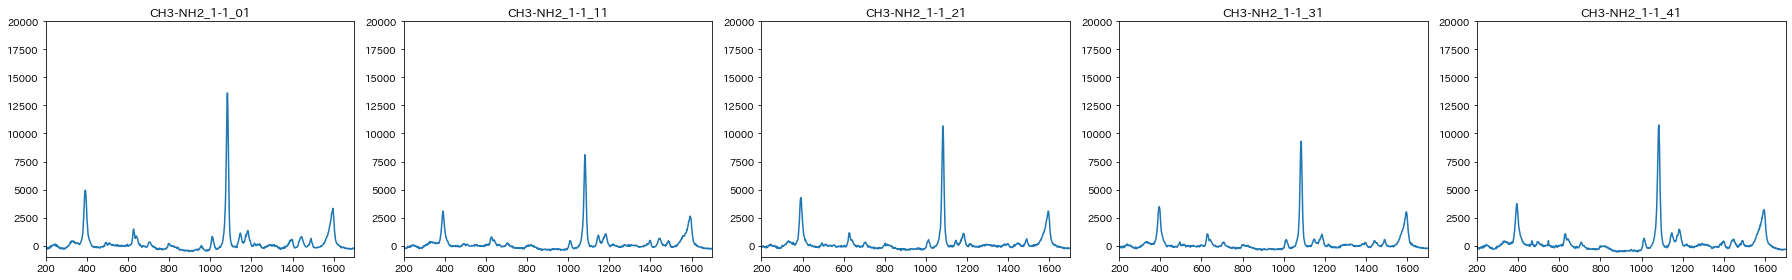

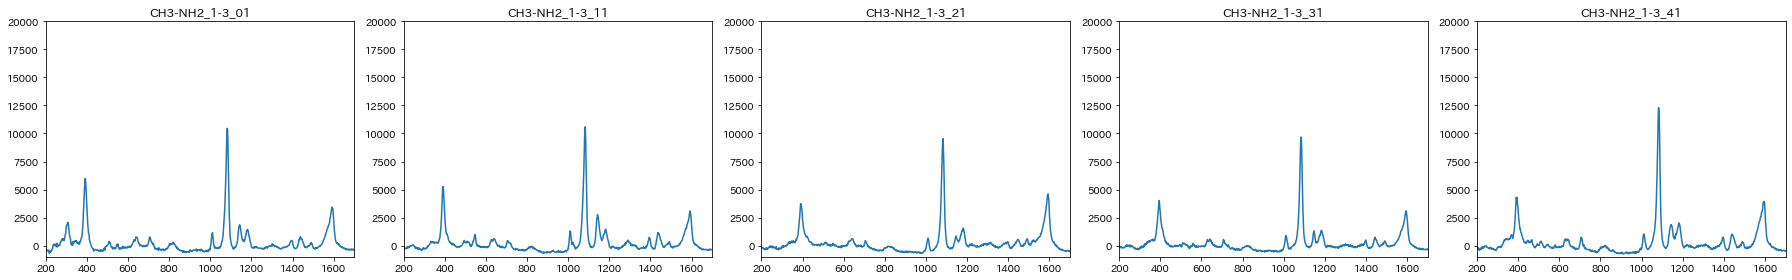

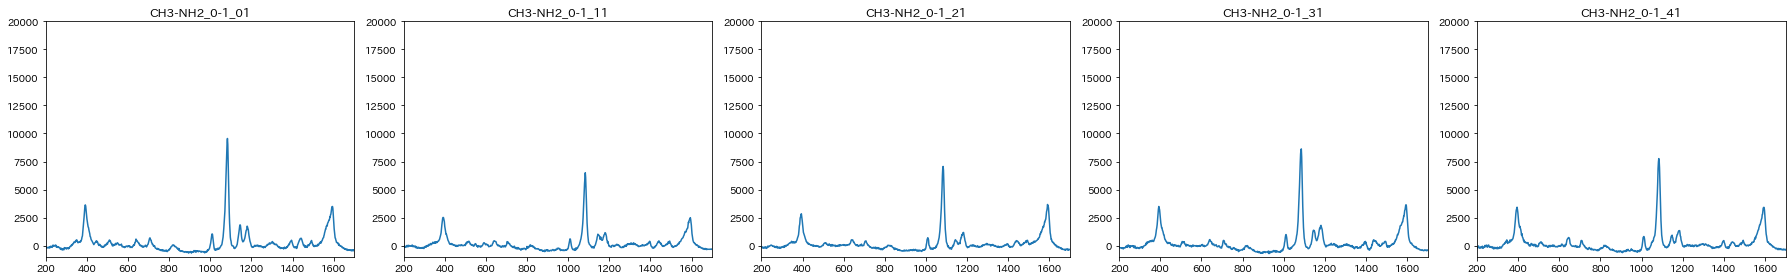

In [24]:
show_raman_spectra(df_list)

# スペクトルデータの正規化

In [25]:
scaled_df_list = []

# 最大強度を1にスケール化
for df in df_list:
    yaxis_list = [y for y in df.columns if not 'Raman Shift' in y]

    scaler = MinMaxScaler()
    series = scaler.fit_transform(df[yaxis_list])
    scaled_df = pd.DataFrame(series)
    scaled_df.columns = yaxis_list
    scaled_df.insert(0, 'Raman Shift', df['Raman Shift'])

    scaled_df_list.append(scaled_df)

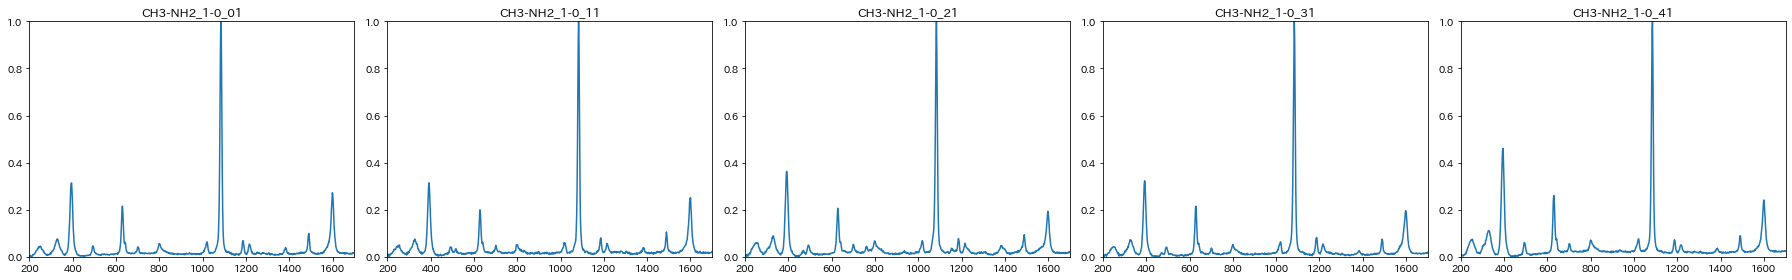

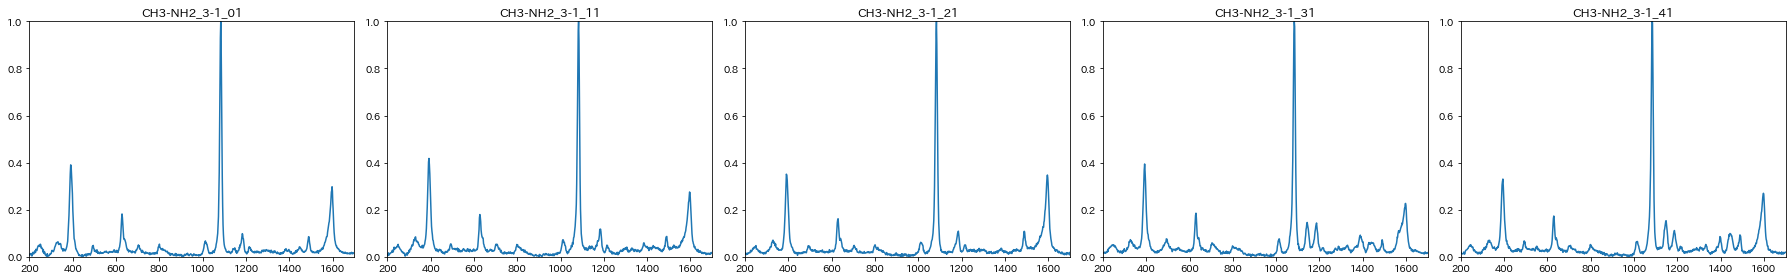

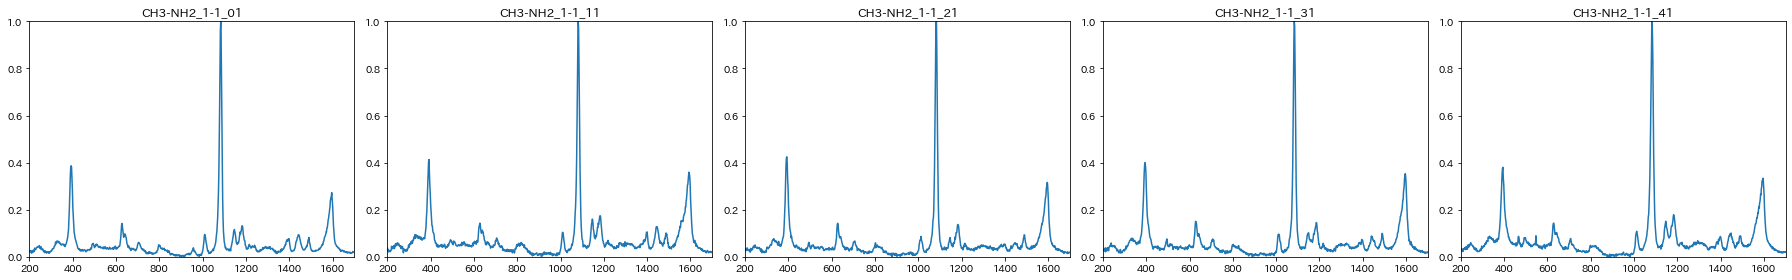

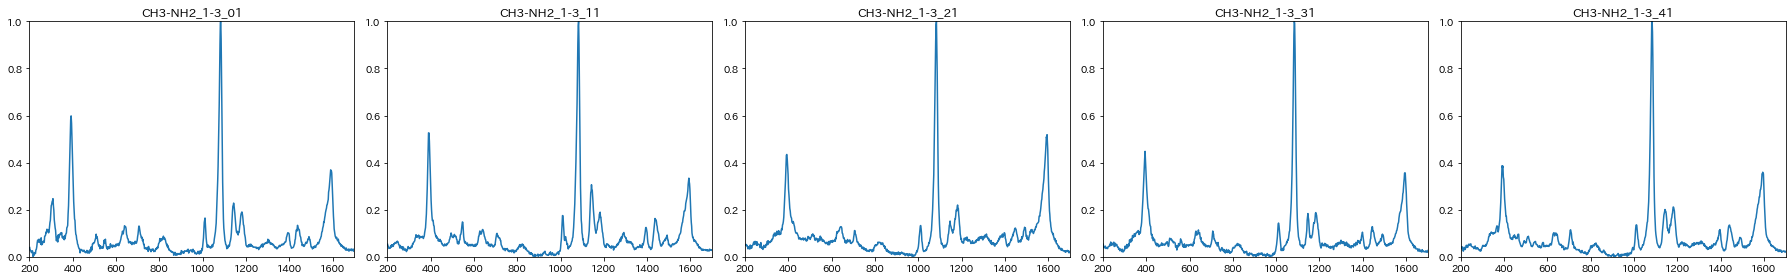

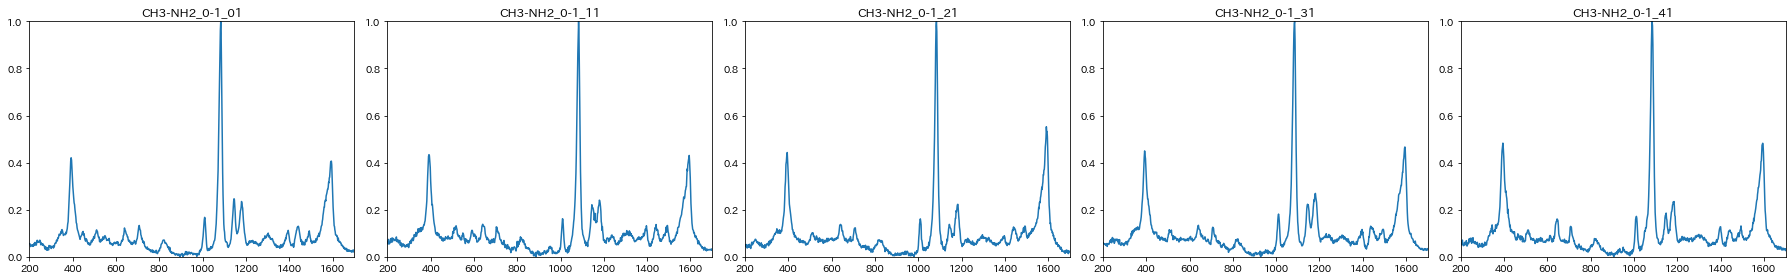

In [26]:
# Y軸の最大・最小の設定
YLIM_MIN = 0
YLIM_MAX = 1

show_raman_spectra(scaled_df_list)

In [27]:
# 解析用にデータフレームの形状を変更
RAMAN_SHIFT = df_list[0]['Raman Shift']
# label_list = ['CH3:COOH=1:0', 'CH3:COOH=3:1', 'CH3:COOH=1:1', 'CH3:COOH=1:3', 'CH3:COOH=0:1']
# label_list = ['CH3:OH=1:0', 'CH3:OH=3:1', 'CH3:OH=1:1', 'CH3:OH=1:3', 'CH3:OH=0:1']
label_list = ['CH3:NH2=1:0', 'CH3:NH2=3:1', 'CH3:NH2=1:1', 'CH3:NH2=1:3', 'CH3:NH2=0:1']
# label_list = ['CH3:COOH=0:1', 'CH3:COOH=1:3', 'CH3:COOH=1:1', 'CH3:COOH=3:1', 'CH3:COOH=1:0', 'CH3:NH2=3:1', 'CH3:NH2=1:1', 'CH3:NH2=1:3', 'CH3:NH2=0:1']

for n, df in enumerate(scaled_df_list):
    df.loc[-1] = int(n)

data_df = pd.concat(scaled_df_list, axis=1)
data_df = data_df.drop(['Raman Shift'], axis=1)
data_df = data_df.T
# labelのみ別で保存
data_label = data_df[-1]
# label無しのデータフレーム
data_df = data_df.drop(-1, axis=1)
data_df.columns = RAMAN_SHIFT

# スペクトルデータの標準化（変数方向）

In [28]:
standerd_df_list = []

# スペクトルを波数方向に標準化
for df in df_list:
    yaxis_list = [y for y in df.columns if not 'Raman Shift' in y]

    scaler = StandardScaler()
    series = scaler.fit_transform(df[yaxis_list])
    standerd_df = pd.DataFrame(series)
    standerd_df.columns = yaxis_list
    standerd_df.insert(0, 'Raman Shift', df['Raman Shift'])

    standerd_df_list.append(standerd_df)

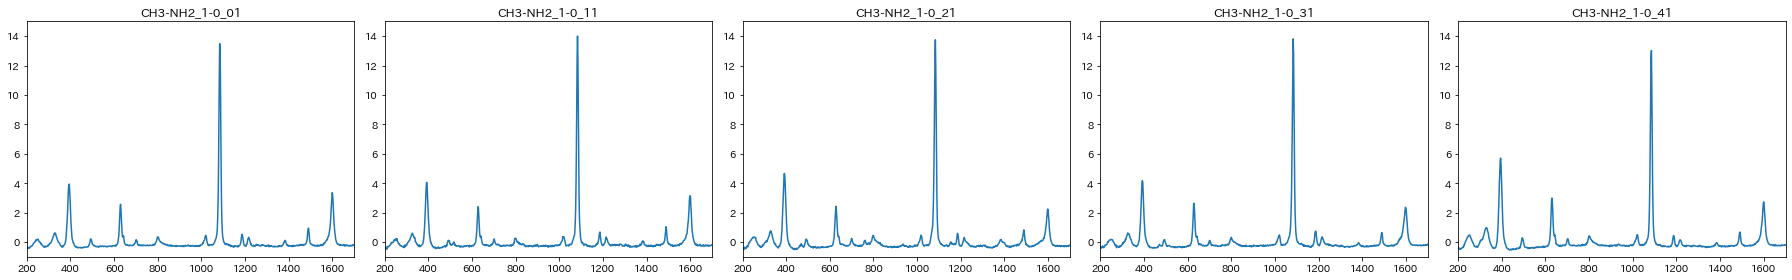

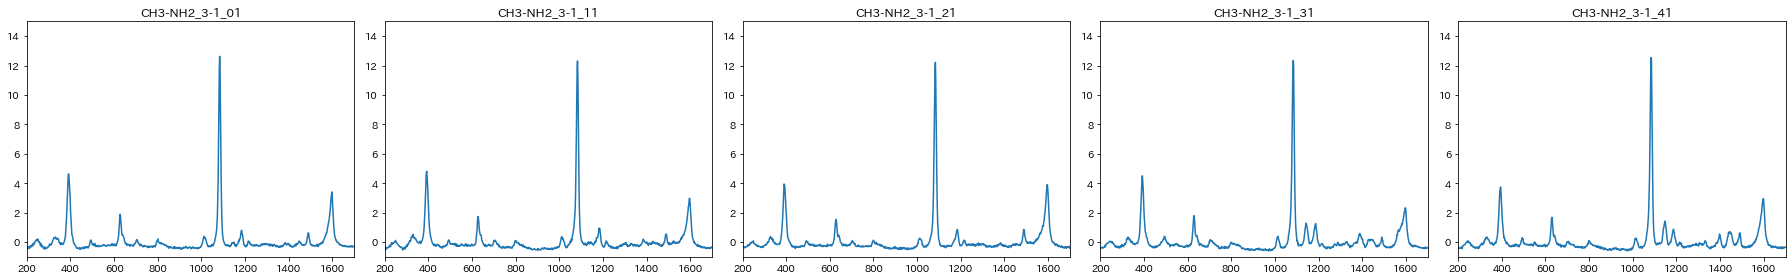

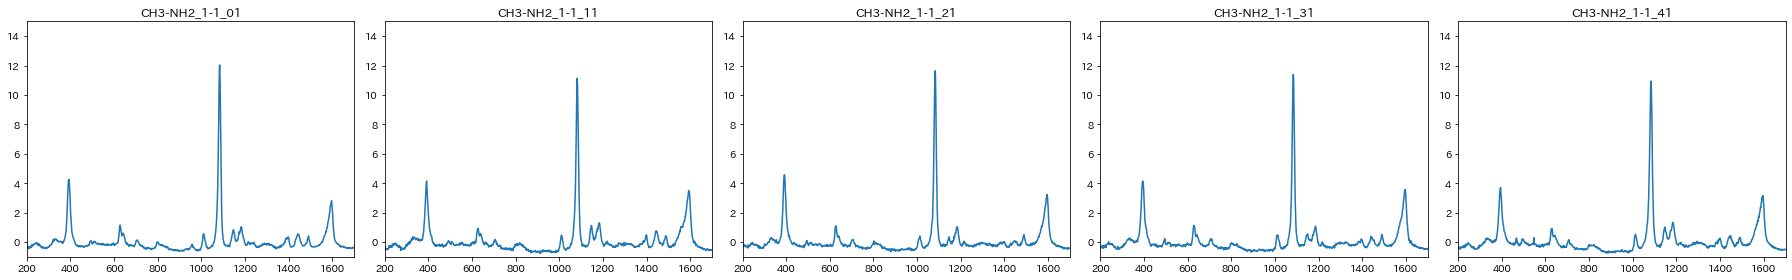

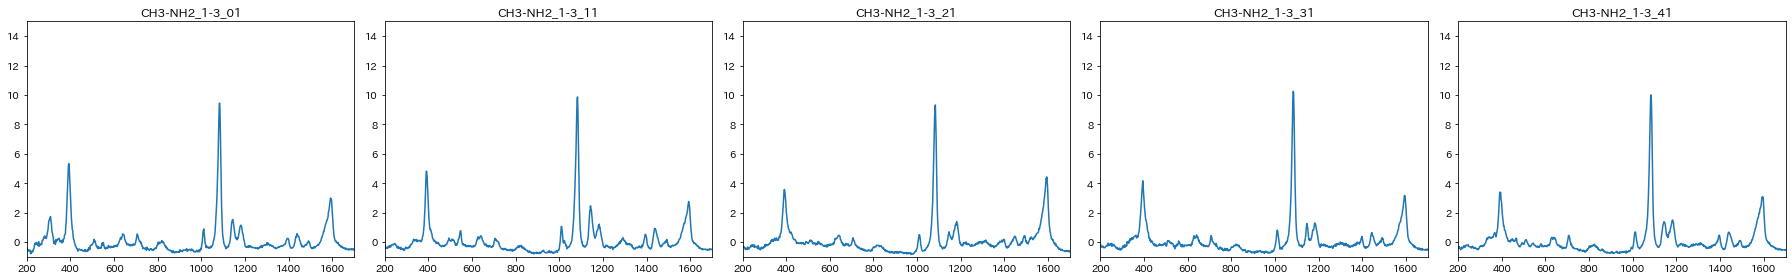

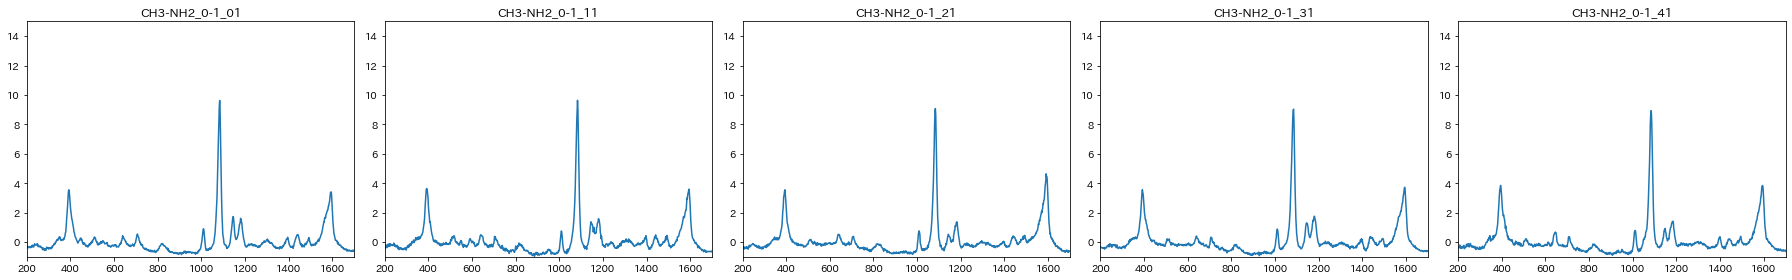

In [29]:
# Y軸の最大・最小の設定
YLIM_MIN = -1
YLIM_MAX = 15

show_raman_spectra(standerd_df_list)

In [30]:
# 解析用に形状変更
for n, df in enumerate(standerd_df_list):
    df.loc[-1] = int(n)

std_data_df = pd.concat(standerd_df_list, axis=1)
std_data_df = std_data_df.drop(['Raman Shift'], axis=1)
std_data_df = std_data_df.T
# labelのみ別で保存
std_data_label = std_data_df[-1]
# label無しのデータフレーム
std_data_df = std_data_df.drop(-1, axis=1)
std_data_df.columns = RAMAN_SHIFT

# データフレームの保存

In [31]:
df_title = 'CH3_NH2_scaled_df'
save_df = data_df.copy()
save_df['label'] = data_label
save_df.to_pickle(output_path + df_title + '.pkl')

df_title = 'CH3_NH2_stander_df'
save_df = std_data_df.copy()
save_df['label'] = std_data_label
save_df.to_pickle(output_path + df_title + '.pkl')

# 各データの相関確認

<AxesSubplot:xlabel='Raman Shift', ylabel='Raman Shift'>

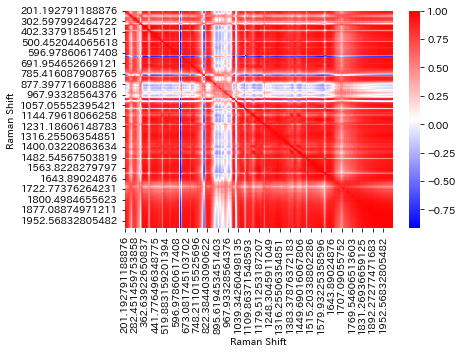

In [16]:
# 正規化データの相関
sns.heatmap(data_df.corr(), cmap="bwr")

<AxesSubplot:xlabel='Raman Shift', ylabel='Raman Shift'>

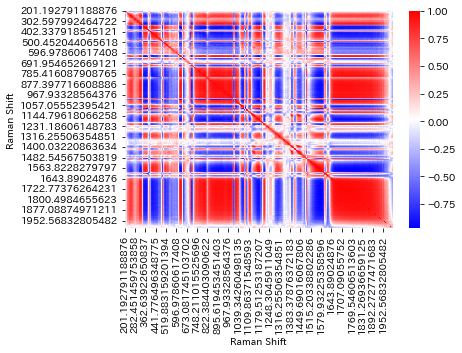

In [17]:
# 標準化データの相関
sns.heatmap(std_data_df.corr(), cmap="bwr")

# PCAによるスペクトルの2次元化

In [32]:
def pca_2d_plot(df, df_label):
    pca = PCA(n_components=2)

    pca_X = pca.fit_transform(df.values)
    pca_result_df = pd.DataFrame(pca_X)
    pca_result_df.columns = ['PC1', 'PC2']
    pca_result_df['label'] = df_label.values

    color_list =['red', 'orange', 'green', 'blue', 'purple', 'cyan', 'glod', 'grey', 'black']

    for i in range(np.unique(data_label).size):
        data = pca_result_df[pca_result_df['label'] == i]
        plt.scatter(data['PC1'], data['PC2'], c=color_list[i], label=label_list[i])

    # 寄与率の算出
    exp_var_ratio = pd.DataFrame([pca.explained_variance_ratio_], columns=['PC1', 'PC2'])
    print(exp_var_ratio)

    #各主成分の固有ベクトル
    pca_vec_df = pd.DataFrame(pca.components_, columns=data_df.columns, index=['PC1', 'PC2'])

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(loc='best')
    plt.show()

    return pca_result_df, pca_vec_df

## 正規化データ

        PC1       PC2
0  0.800328  0.059049


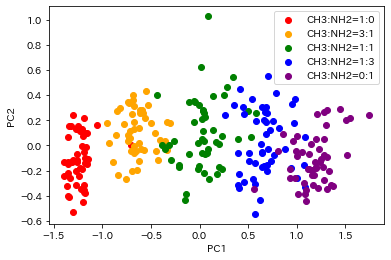

In [33]:
scaled_pca_result_df, scaled_pca_vec_df = pca_2d_plot(data_df, data_label)

<AxesSubplot:xlabel='Raman Shift'>

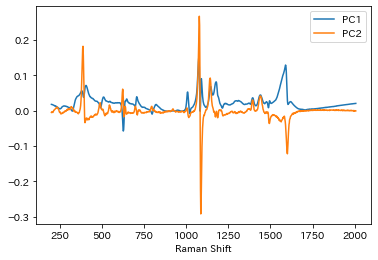

In [34]:
# 固有ベクトルの可視化
scaled_pca_vec_df.T.plot()

## 標準化データ

        PC1      PC2
0  0.652626  0.11506


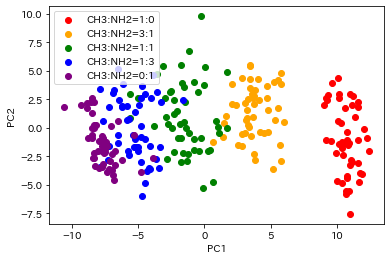

In [35]:
standerd_pca_result_df, standerd_pca_vec_df = pca_2d_plot(std_data_df, std_data_label)

<AxesSubplot:xlabel='Raman Shift'>

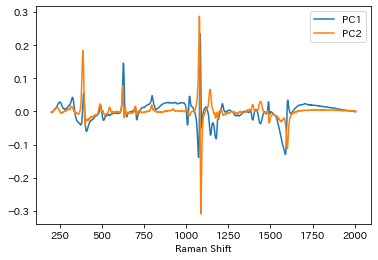

In [36]:
# 固有ベクトルの可視化
standerd_pca_vec_df.T.plot()

# PCA_SVM

In [37]:
def pca_svm(n_comp, C, data_df, label):
    # PCA処理
    pca = PCA(n_components=n_comp)
    X = pca.fit_transform(data_df.values)
    result_df = pd.DataFrame(X)
    result_df.columns = [f'PC{n+1}' for n in range(n_comp)]
    result_df['label'] = label.values

    # 寄与率の算出
    df_exp_var_ratio = pd.DataFrame([pca.explained_variance_ratio_],columns=[f'PC{n+1}' for n in range(n_comp)])
    #各主成分の固有ベクトル
    pca_vec_df = pd.DataFrame(pca.components_, columns=data_df.columns, index=[f'PC{n+1}' for n in range(n_comp)])

    # SVM処理
    # 特徴量とラベルの分割
    X = result_df[result_df.columns[result_df.columns != 'label']]
    y = result_df['label']
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        svm_model = SVC(C=C)
        svm_model.fit(train_x, train_y)
        y_pred = svm_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return df_exp_var_ratio, pca_vec_df, cm, Accuracy

## クロスバリデーションによる評価

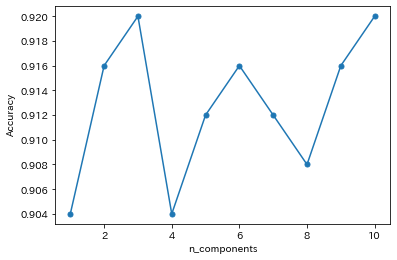

In [38]:
# n_componentsの決定
temp_accuracy_dict = {}

for n_comp in range(1, 11, 1):
    _, _, _, accuracy = pca_svm(n_comp, 1, data_df, data_label)
    temp_accuracy_dict[n_comp] = accuracy

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('n_components')
plt.ylabel('Accuracy')
plt.show()

In [43]:
# n_components = 2
raitio, _, cm, accuracy = pca_svm(3, 1, data_df, data_label)
print(raitio)
print(accuracy)

        PC1       PC2       PC3
0  0.800328  0.059049  0.034081
0.92


<AxesSubplot:>

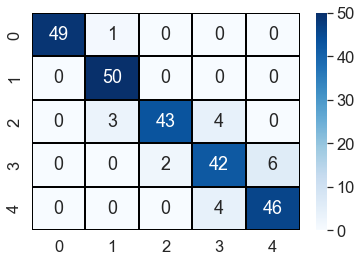

In [44]:
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 学習データによる評価

In [45]:
# train_accuracy計算用
def train_pca_svm(n_comp, C, data_df, label):
    # PCA処理
    pca = PCA(n_components=n_comp)
    X = pca.fit_transform(data_df.values)
    result_df = pd.DataFrame(X)
    result_df.columns = [f'PC{n+1}' for n in range(n_comp)]
    result_df['label'] = label.values

    # 寄与率の算出
    df_exp_var_ratio = pd.DataFrame([pca.explained_variance_ratio_],columns=[f'PC{n+1}' for n in range(n_comp)])
    #各主成分の固有ベクトル
    pca_vec_df = pd.DataFrame(pca.components_, columns=data_df.columns, index=[f'PC{n+1}' for n in range(n_comp)])

    # SVM処理
    # 特徴量とラベルの分割
    X = result_df[result_df.columns[result_df.columns != 'label']]
    y = result_df['label']

    svm_model = SVC(C=C)
    svm_model.fit(X, y)
    y_pred = svm_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)


    return df_exp_var_ratio, pca_vec_df, cm, Accuracy

In [46]:
# train_accuracy
train_raitio, _, train_cm, train_accuracy = train_pca_svm(3, 1, data_df, data_label)
print(train_raitio)
print(train_accuracy)

        PC1       PC2       PC3
0  0.800328  0.059049  0.034081
0.924


<AxesSubplot:>

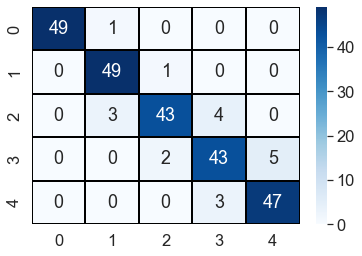

In [47]:
sns.set(font_scale=1.5)
sns.heatmap(train_cm, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 標準化データによる評価

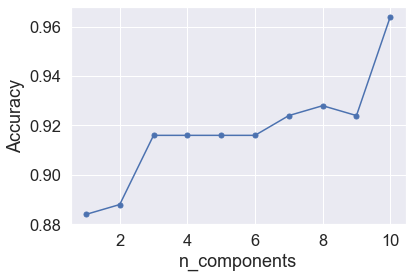

In [48]:
# n_componentsの決定
temp_accuracy_dict = {}

for n_comp in range(1, 11, 1):
    _, _, _, accuracy = pca_svm(n_comp, 1, std_data_df, std_data_label)
    temp_accuracy_dict[n_comp] = accuracy

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('n_components')
plt.ylabel('Accuracy')
plt.show()

In [51]:
# 標準化データでの予測
std_raitio, _, std_cm, std_accuracy = pca_svm(10, 10, std_data_df, data_label)
print(std_raitio)
print(std_accuracy)

        PC1      PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.652626  0.11506  0.057244  0.043493  0.016535  0.012867  0.010043   

        PC8       PC9      PC10  
0  0.006731  0.005454  0.005107  
0.992


<AxesSubplot:>

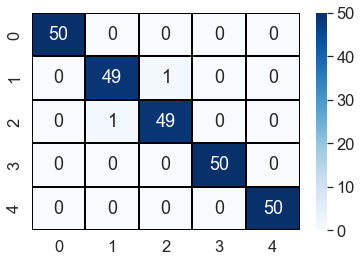

In [52]:
sns.set(font_scale=1.5)
sns.heatmap(std_cm, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# SVM単体での解析

In [53]:
# kernel:rbf(ガウス関数) その他：linear(線形回帰)、poly(多項式展開)、sigmoidなどがある
def svm_only(C, data_df, label):
    # SVM処理
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        svm_model = SVC(C=C)
        svm_model.fit(train_x, train_y)
        y_pred = svm_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

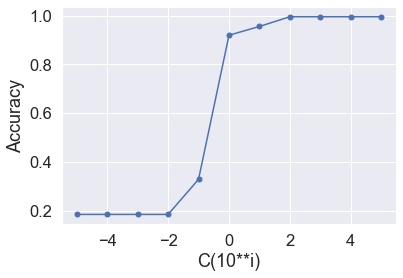

In [54]:
# Cの決定
temp_accuracy_dict = {}

for i in range(-5, 6, 1):
    _, accuracy_svm = svm_only(10**i, data_df, data_label)
    temp_accuracy_dict[i] = accuracy_svm

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('C(10**i)')
plt.ylabel('Accuracy')
plt.show()

In [55]:
cm_svm, accuracy_svm = svm_only(100, data_df, data_label)
print('Accuracy:', accuracy_svm)

Accuracy: 0.996


<AxesSubplot:>

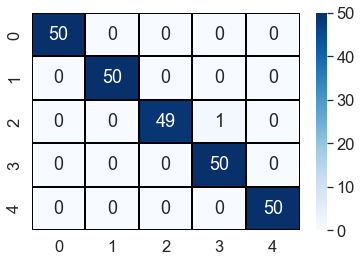

In [56]:
sns.set(font_scale=1.5)
sns.heatmap(cm_svm, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 学習データによる評価

In [57]:
def train_svm_only(C, data_df, label):
    # SVM処理
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label

    svm_model = SVC(C=C)
    svm_model.fit(X, y)
    y_pred = svm_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)

    return cm, Accuracy

In [58]:
train_cm_svm, train_accuracy_svm = train_svm_only(100, data_df, data_label)
print('Accuracy:', train_accuracy_svm)

Accuracy: 1.0


<AxesSubplot:>

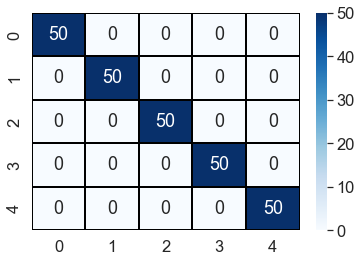

In [59]:
sns.set(font_scale=1.5)
sns.heatmap(train_cm_svm, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 標準化データによる評価

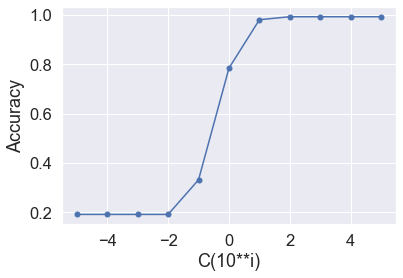

In [60]:
# Cの決定
temp_accuracy_dict = {}

for i in range(-5, 6, 1):
    _, accuracy_svm = svm_only(10**i, std_data_df, std_data_label)
    temp_accuracy_dict[i] = accuracy_svm

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('C(10**i)')
plt.ylabel('Accuracy')
plt.show()

In [61]:
# 標準化データでの予測
std_cm_svm, std_accuracy_svm = svm_only(100, std_data_df, data_label)
print('Accuracy:', std_accuracy_svm)

Accuracy: 0.992


<AxesSubplot:>

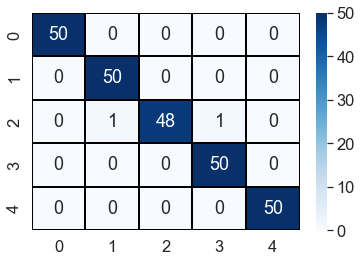

In [62]:
sns.set(font_scale=1.5)
sns.heatmap(std_cm_svm, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# Linear Discriminant Analysis(LDA)

## スペクトルの2次元化

In [63]:
def lda_2D_plot(df, df_label):
    lda = LDA(n_components=2)
    X_r2 = lda.fit(df, df_label).transform(df)

    color_list =['red', 'orange', 'green', 'blue', 'purple', 'cyan', 'glod', 'grey', 'black']

    # Percentage of variance explained for each components
    print('explained variance ratio (first two components): %s' % str(lda.explained_variance_ratio_))

    for i in range(np.unique(data_label).size):
        plt.scatter(X_r2[data_label == i, 0], X_r2[data_label == i, 1],
        c=color_list[i], label=label_list[i])

    # ldaの結果をデータフレーム化
    lda_result_df = pd.DataFrame(X_r2)
    lda_result_df.columns = ['LDA1', 'LDA2']
    lda_result_df['label'] = data_label.values

    plt.xlabel('LDA1')
    plt.ylabel('LDA2')
    plt.legend(loc='best')
    plt.show()

    return lda_result_df

### 正規化データ

explained variance ratio (first two components): [0.95682154 0.03286384]


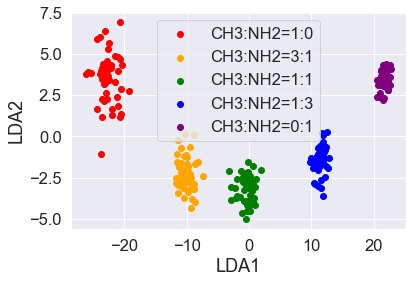

In [64]:
scaled_lda_result_df = lda_2D_plot(data_df, data_label)

### 標準化データ

explained variance ratio (first two components): [0.9541694  0.03568248]


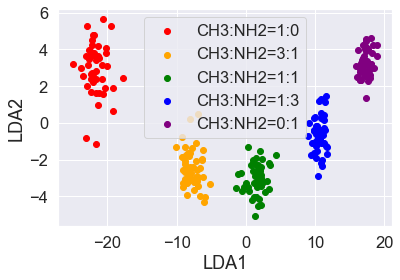

In [65]:
standerd_lda_result_df = lda_2D_plot(std_data_df, std_data_label)

## クロスバリデーションによる評価

In [66]:
def lda_prediction(n_comp, data_df, label):

    X = data_df
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        lda_model = LDA(n_components=n_comp)
        lda_model.fit(train_x, train_y)
        y_pred = lda_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

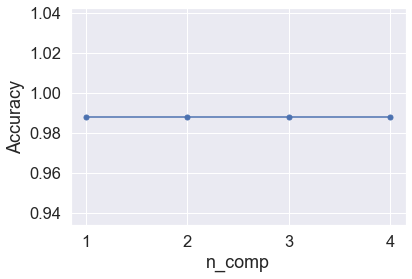

In [67]:
# n_componentsの決定
temp_accuracy_dict = {}

for n_comp in range(1, 5, 1):
    _, accuracy_lda = lda_prediction(n_comp, data_df, data_label)
    temp_accuracy_dict[n_comp] = accuracy_lda

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('n_comp')
plt.ylabel('Accuracy')
plt.show()

In [68]:
cm_lda, accuracy_lda = lda_prediction(2, data_df, data_label)
print('Accuracy:', accuracy_lda)

Accuracy: 0.988


<AxesSubplot:>

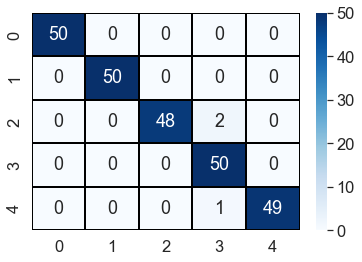

In [69]:
sns.set(font_scale=1.5)
sns.heatmap(cm_lda, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 学習データによる評価

In [70]:
def train_lda_prediction(n_comp, data_df, label):

    X = data_df
    y = label

    lda_model = LDA(n_components=n_comp)
    lda_model.fit(X, y)
    y_pred = lda_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)

    return cm, Accuracy

In [71]:
train_cm_ldan, train_accuracy_ldan = train_lda_prediction(2, data_df, data_label)
print('Accuracy:', train_accuracy_ldan)

Accuracy: 1.0


<AxesSubplot:>

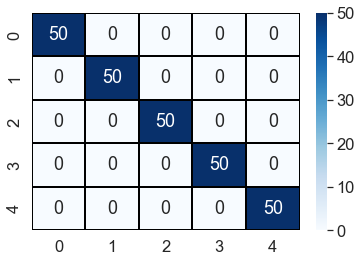

In [72]:
sns.set(font_scale=1.5)
sns.heatmap(train_cm_ldan, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 標準化データによる評価

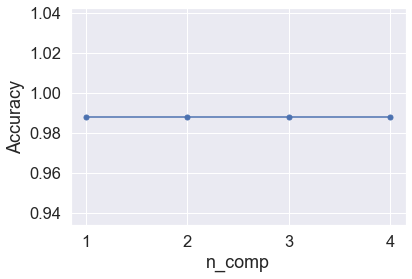

In [73]:
# n_componentsの決定
temp_accuracy_dict = {}

for n_comp in range(1, 5, 1):
    _, accuracy_lda = lda_prediction(n_comp, std_data_df, std_data_label)
    temp_accuracy_dict[n_comp] = accuracy_lda

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('n_comp')
plt.ylabel('Accuracy')
plt.show()

In [76]:
# 標準化データでの予測
std_cm_lda, std_accuracy_lda = lda_prediction(2, std_data_df, std_data_label)
print('Accuracy:', std_accuracy_lda)

Accuracy: 0.988


<AxesSubplot:>

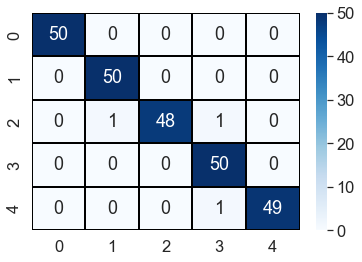

In [77]:
sns.set(font_scale=1.5)
sns.heatmap(std_cm_lda, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# t-SNEによるスペクトルの2次元化

In [78]:
def tsne_2D_plot(df, df_label):
    tsne = TSNE(n_components=2, random_state=0, init='pca')

    X = tsne.fit_transform(df.values)
    tsne_result_df = pd.DataFrame(X)
    tsne_result_df.columns = ['tSNE1', 'tSNE2']
    tsne_result_df['label'] = df_label.values

    color_list =['red', 'orange', 'green', 'blue', 'purple', 'cyan', 'glod', 'grey', 'black']

    for i in range(np.unique(df_label).size):
        data = tsne_result_df[tsne_result_df['label'] == i]
        plt.scatter(data['tSNE1'], data['tSNE2'], c=color_list[i], label=label_list[i])

    plt.xlabel('tSNE1')
    plt.ylabel('tSNE2')
    plt.legend(loc='best')
    plt.show()

    return tsne_result_df

## 正規化データ

c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


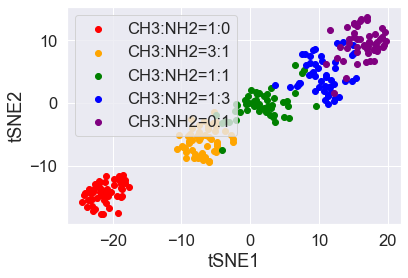

In [79]:
scaled_tsne_result_df = tsne_2D_plot(data_df, data_label)

## 標準化データ

c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


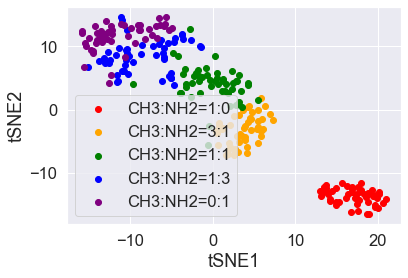

In [80]:
standerd_tsne_result_df = tsne_2D_plot(std_data_df, std_data_label)

# t-SNE_SVM

In [81]:
def tsne_svm(n_comp, C, data_df, label):
    # t-SNE処理
    tsne = TSNE(n_components=n_comp, random_state=0, init='pca')
    X = tsne.fit_transform(data_df.values)
    result_df = pd.DataFrame(X)
    result_df.columns = [f'TSNE{n+1}' for n in range(n_comp)]
    result_df['label'] = label.values

    # SVM処理
    # 特徴量とラベルの分割
    X = result_df[result_df.columns[result_df.columns != 'label']]
    y = result_df['label']
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        svm_model = SVC(C=C)
        svm_model.fit(train_x, train_y)
        y_pred = svm_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifo

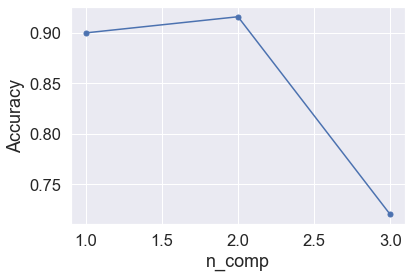

In [82]:
# n_componentsの決定
temp_accuracy_dict = {}

for n_comp in range(1, 4, 1):
    _, accuracy_tsne_svm = tsne_svm(n_comp, 1, data_df, data_label)
    temp_accuracy_dict[n_comp] = accuracy_tsne_svm

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('n_comp')
plt.ylabel('Accuracy')
plt.show()

c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifo

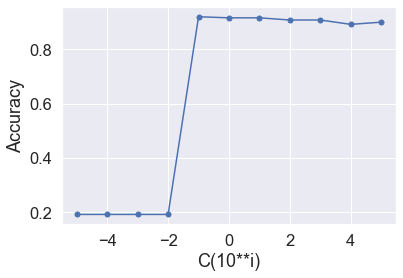

In [83]:
# Cの決定
temp_accuracy_dict = {}

for i in range(-5, 6, 1):
    _, accuracy_tsne_svm = tsne_svm(2, 10**i, data_df, data_label)
    temp_accuracy_dict[i] = accuracy_tsne_svm

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('C(10**i)')
plt.ylabel('Accuracy')
plt.show()

In [86]:
# componet=2
cm_tsne_svm, accuracy_tsne_svm = tsne_svm(2, 0.1, data_df, data_label)
print('Accuracy:', accuracy_tsne_svm)

c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Accuracy: 0.92


<AxesSubplot:>

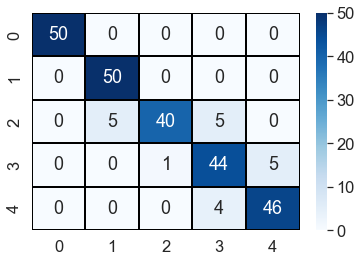

In [87]:
sns.set(font_scale=1.5)
sns.heatmap(cm_tsne_svm, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 学習データによる評価

In [88]:
def train_tsne_svm(n_comp, C, data_df, label):
    # t-SNE処理
    tsne = TSNE(n_components=n_comp, random_state=0, init='pca')
    X = tsne.fit_transform(data_df.values)
    result_df = pd.DataFrame(X)
    result_df.columns = [f'TSNE{n+1}' for n in range(n_comp)]
    result_df['label'] = label.values

    # SVM処理
    # 特徴量とラベルの分割
    X = result_df[result_df.columns[result_df.columns != 'label']]
    y = result_df['label']

    svm_model = SVC(C=C)
    svm_model.fit(X, y)
    y_pred = svm_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)

    return cm, Accuracy

In [89]:
# componet=2
train_cm_tsne_svm, train_accuracy_tsne_svm = train_tsne_svm(2, 0.1, data_df, data_label)
print('Accuracy:', train_accuracy_tsne_svm)

c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Accuracy: 0.916


<AxesSubplot:>

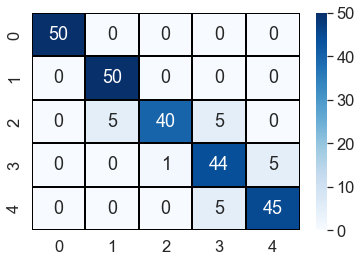

In [90]:
sns.set(font_scale=1.5)
sns.heatmap(train_cm_tsne_svm, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 標準化データによる評価

c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifo

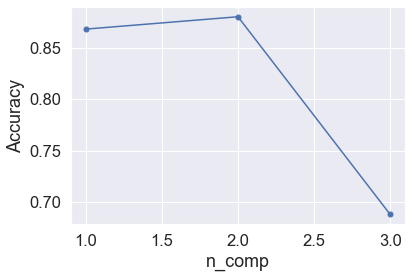

In [91]:
# n_componentsの決定
temp_accuracy_dict = {}

for n_comp in range(1, 4, 1):
    _, accuracy_tsne_svm = tsne_svm(n_comp, 1, std_data_df, std_data_label)
    temp_accuracy_dict[n_comp] = accuracy_tsne_svm

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('n_comp')
plt.ylabel('Accuracy')
plt.show()

c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifo

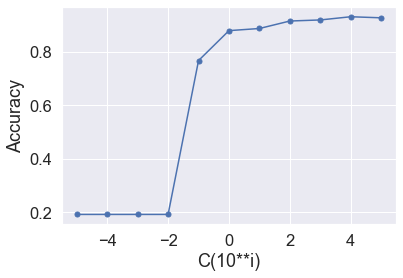

In [92]:
# Cの決定
temp_accuracy_dict = {}

for i in range(-5, 6, 1):
    _, accuracy_tsne_svm = tsne_svm(2, 10**i, std_data_df, std_data_label)
    temp_accuracy_dict[i] = accuracy_tsne_svm

temp_accuracy_list = temp_accuracy_dict.items()
x, y = zip(*temp_accuracy_list)

plt.plot(x, y, marker='o', markersize=5)
plt.xlabel('C(10**i)')
plt.ylabel('Accuracy')
plt.show()

In [93]:
# 標準化データでの予測
std_cm_tsne_svm, std_accuracy_tsne_svm = tsne_svm(2, 10000, std_data_df, std_data_label)
print('Accuracy:', std_accuracy_tsne_svm)

c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\west7\anaconda3\envs\xeus-python\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Accuracy: 0.932


<AxesSubplot:>

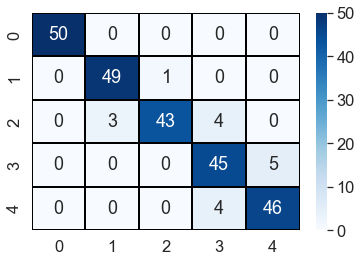

In [94]:
sns.set(font_scale=1.5)
sns.heatmap(std_cm_tsne_svm, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# 決定木

## クロスバリデーションによる評価

In [95]:
dt_model = DecisionTreeClassifier(random_state=1234)

# 施行するパラメータを設定
params = {
	'max_depth':[i for i in range(3, 11, 1)],
	'min_samples_split':[i for i in range(2, 11, 1)],
	'min_samples_leaf':[i for i in range(1, 11, 1)]
}

grid_search = GridSearchCV(dt_model, param_grid=params, cv=5)
grid_search.fit(data_df, data_label)

# ベストスコアを表示
print(grid_search.best_score_)
# ベストスコアのパラメータを表示
print(grid_search.best_params_)

0.944
{'max_depth': 4, 'min_samples_leaf': 6, 'min_samples_split': 2}


In [101]:
def decision_tree(max_depth, min_leaf, min_split, data_df, label):
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        dt_model = DecisionTreeClassifier(max_depth=max_depth,
                                        min_samples_split=min_split,
                                        min_samples_leaf=min_leaf,
                                        max_leaf_nodes=None,
                                        random_state=1234)

        dt_model.fit(train_x, train_y)
        y_pred = dt_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

In [102]:
cm_dt, accuracy_dt = decision_tree(4, 6, 2, data_df, data_label)
print('Accuracy:', accuracy_dt)

Accuracy: 0.932


<AxesSubplot:>

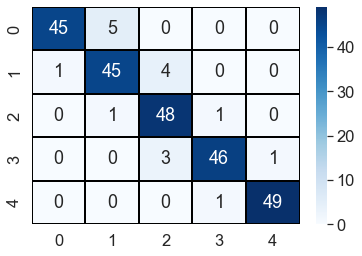

In [103]:
sns.set(font_scale=1.5)
sns.heatmap(cm_dt, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 学習データによる評価

In [104]:
def train_decision_tree(max_depth, min_leaf, min_split, data_df, label):
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label

    dt_model = DecisionTreeClassifier(max_depth=max_depth,
                                        min_samples_split=min_split,
                                        min_samples_leaf=min_leaf,
                                        max_leaf_nodes=None,
                                        random_state=1234)

    dt_model.fit(X, y)
    y_pred = dt_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)

    return cm, Accuracy

In [105]:
train_cm_dt, train_accuracy_dt = train_decision_tree(4, 6, 2, data_df, data_label)
print('Accuracy:', train_accuracy_dt)

Accuracy: 0.984


<AxesSubplot:>

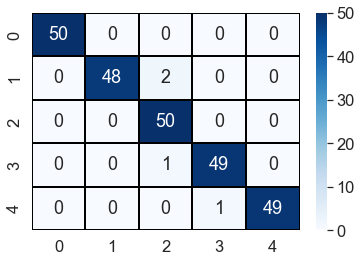

In [106]:
sns.set(font_scale=1.5)
sns.heatmap(train_cm_dt, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 標準化データによる評価

In [112]:
dt_model = DecisionTreeClassifier(random_state=1234)

# 施行するパラメータを設定
params = {
	'max_depth':[i for i in range(3, 11, 1)],
	'min_samples_split':[i for i in range(2, 11, 1)],
	'min_samples_leaf':[i for i in range(1, 11, 1)]
}

grid_search = GridSearchCV(dt_model, param_grid=params, cv=5)
grid_search.fit(std_data_df, std_data_label)

# ベストスコアを表示
print(grid_search.best_score_)
# ベストスコアのパラメータを表示
print(grid_search.best_params_)

0.968
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [121]:
std_cm_dt, std_accuracy_dt = decision_tree(5, 6, 2, std_data_df, std_data_label)
print('Accuracy:', std_accuracy_dt)

Accuracy: 0.976


<AxesSubplot:>

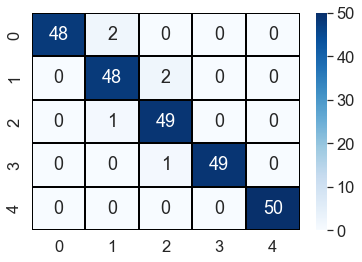

In [122]:
sns.set(font_scale=1.5)
sns.heatmap(std_cm_dt, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# MLPによるクラスタリング

In [123]:
MLP_model = MLPClassifier(max_iter=5000, random_state=1234)

# 施行するパラメータを設定
params = {
	'hidden_layer_sizes':[(100), (200), (300), (50, 50), (50, 100), (100, 50), (100, 100), (200, 100), (200, 200)],
	'activation':['logistic', 'tanh', 'relu'],
	'solver':['sgd', 'adam']
}

X = data_df.copy()
X.columns = [str(i) for i in data_df.columns]

grid_search = GridSearchCV(MLP_model, param_grid=params, cv=5)
grid_search.fit(X, data_label)

# ベストスコアを表示
print(grid_search.best_score_)
# ベストスコアのパラメータを表示
print(grid_search.best_params_)

0.9879999999999999
{'activation': 'logistic', 'hidden_layer_sizes': (50, 100), 'solver': 'adam'}


In [124]:
def MLP(hidden_layer, activ, solv, data_df, label):
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label
    oof = np.zeros(len(y))

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_idx, val_idx in kf.split(X):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

        MLP_model = MLPClassifier(hidden_layer_sizes=hidden_layer,
                                activation=activ, # logistic, tanh, relu
                                solver=solv,
                                max_iter=5000,
                                random_state=1234)

        MLP_model.fit(train_x, train_y)
        y_pred = MLP_model.predict(val_x)
        oof[val_idx] = y_pred

    cm = confusion_matrix(y, oof)
    # 正解率
    Accuracy = accuracy_score(y, oof)

    return cm, Accuracy

In [125]:
cm_MLP, accuracy_MLP= MLP((50, 100), 'logistic', 'adam', data_df, data_label)
print('Accuracy:', accuracy_MLP)

Accuracy: 0.992


<AxesSubplot:>

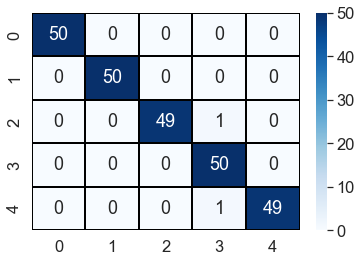

In [126]:
sns.set(font_scale=1.5)
sns.heatmap(cm_MLP, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 学習データによる評価

In [177]:
def train_MLP(hidden_layer, activ, solv, data_df, label):
    # 特徴量とラベルの分割
    X = data_df
    X.columns = [str(i) for i in data_df.columns]
    y = label

    MLP_model = MLPClassifier(hidden_layer_sizes=hidden_layer,
                                activation=activ,
                                solver=solv,
                                max_iter=5000,
                                random_state=1234)

    MLP_model.fit(X, y)
    y_pred = MLP_model.predict(X)

    cm = confusion_matrix(y, y_pred)
    # 正解率
    Accuracy = accuracy_score(y, y_pred)

    return cm, Accuracy

In [127]:
train_cm_MLP, train_accuracy_MLP = MLP((50, 100), 'logistic', 'adam', data_df, data_label)
print('Accuracy:', train_accuracy_MLP)

Accuracy: 0.992


<AxesSubplot:>

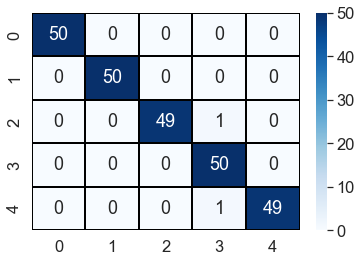

In [128]:
sns.set(font_scale=1.5)
sns.heatmap(train_cm_MLP, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

## 標準化データによる評価

In [129]:
MLP_model = MLPClassifier(max_iter=5000, random_state=1234)

# 施行するパラメータを設定
params = {
	'hidden_layer_sizes':[(100), (200), (300), (50, 50), (50, 100), (100, 50), (100, 100), (200, 100), (200, 200)],
	'activation':['logistic', 'tanh', 'relu'],
	'solver':['sgd', 'adam']
}

X = std_data_df.copy()
X.columns = [str(i) for i in std_data_df.columns]

grid_search = GridSearchCV(MLP_model, param_grid=params, cv=5)
grid_search.fit(X, std_data_label)

# ベストスコアを表示
print(grid_search.best_score_)
# ベストスコアのパラメータを表示
print(grid_search.best_params_)

0.9879999999999999
{'activation': 'relu', 'hidden_layer_sizes': (50, 100), 'solver': 'adam'}


In [130]:
# 標準化データでの予測
std_cm_MLP, std_accuracy_MLP = MLP((50, 100), 'relu', 'adam', std_data_df, data_label)
print('Accuracy:', std_accuracy_MLP)

Accuracy: 0.98


<AxesSubplot:>

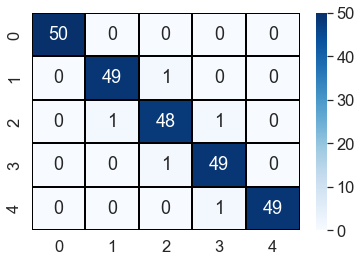

In [131]:
sns.set(font_scale=1.5)
sns.heatmap(std_cm_MLP, annot=True, cmap='Blues', linecolor='black', linewidths=1.5)

# 各データ（スペクトル、PCA、LDA、tSNE）のExcel化

In [132]:
graph_title = 'CH3_NH2_raw_data'

with pd.ExcelWriter(output_path + graph_title + '.xlsx') as writer:
    for n, df in enumerate(df_list):
        df.to_excel(writer, sheet_name=f'data_{n+1}', index=False)

In [133]:
graph_title = 'scaled_pca_result'
scaled_pca_result_df.to_excel(output_path + graph_title + '.xlsx', index=False)

graph_title = 'standerd_pca_result'
standerd_pca_result_df.to_excel(output_path + graph_title + '.xlsx', index=False)

In [134]:
graph_title = 'scaled_vector'
scaled_pca_vec_df.T.to_excel(output_path + graph_title + '.xlsx', index=False)

graph_title = 'standerd_vector'
standerd_pca_vec_df.T.to_excel(output_path + graph_title + '.xlsx', index=False)

In [135]:
graph_title = 'scaled_lda_result'
scaled_lda_result_df.to_excel(output_path + graph_title + '.xlsx', index=False)

graph_title = 'standerd_lda_result'
standerd_lda_result_df.to_excel(output_path + graph_title + '.xlsx', index=False)

In [136]:
graph_title = 'scaled_tsne_result'
scaled_tsne_result_df.to_excel(output_path + graph_title + '.xlsx', index=False)

graph_title = 'standerd_tsne_result'
standerd_tsne_result_df.to_excel(output_path + graph_title + '.xlsx', index=False)